In [1]:
import torch
from GCN.data_processing import Data_Loader
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
from torchvision.models.feature_extraction import create_feature_extractor
import csv
import numpy as np
import io
import os, random
import time
import json
import torch
import zipfile
import numpy as np
import torch.nn as nn
from PIL import Image,ImageOps
import torch.nn.functional as F
from einops import rearrange, repeat
import math
from torch import einsum
from argparse import ArgumentParser
from core.models.curvenet_cls import CurveNet
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import argparse
random_seed = 420 #for reproducibility
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torchsummary import summary
import colorama
from colorama import Fore, Back, Style
colorama.init(autoreset=True)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
!nvidia-smi

Mon Sep 18 08:23:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.86       Driver Version: 526.86       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |True

| N/A   73C    P8     4W /  N/A |    262MiB /  4096MiB |      9%      Default |
1
|                               |                      |                  N/A |NVIDIA GeForce GTX 1650

+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      3480    C+G   C:\Windows\explorer.exe         N/A      |
|    0   N/A  N/A      4060    C+G   ...8bbwe\WindowsTerminal.exe    N/A      |
|    0   

In [4]:
# print(len(np.unique(train_y)))
# print(np.unique(train_y))

|    0   N/A  N/A      8020    C+G   ...wekyb3d8bbwe\Video.UI.exe    N/A      |
|    0   N/A  N/A      8428    C+G   ...artMenuExperienceHost.exe    N/A      |
|    0   N/A  N/A      8768    C+G   ...045.31\msedgewebview2.exe    N/A      |
|    0   N/A  N/A      9284    C+G   ...n1h2txyewy\SearchHost.exe    N/A      |
|    0   N/A  N/A     12080    C+G   ...e\PhoneExperienceHost.exe    N/A      |
|    0   N/A  N/A     12144    C+G   ...2txyewy\TextInputHost.exe    N/A      |
|    0   N/A  N/A     13020    C+G   ...perience\NVIDIA Share.exe    N/A      |
|    0   N/A  N/A     14224    C+G   ...ray\lghub_system_tray.exe    N/A      |


In [5]:
# print(len(train_x))
# print(len(train_y))
# print(len(test_x))
# print(len(test_y))

|    0   N/A  N/A     14912    C+G   ...ation\Adaware-Privacy.exe    N/A      |
|    0   N/A  N/A     15128    C+G   ...ype for Desktop\Skype.exe    N/A      |
|    0   N/A  N/A     15288    C+G   ...ype for Desktop\Skype.exe    N/A      |
|    0   N/A  N/A     16764    C+G   ...938.81\msedgewebview2.exe    N/A      |
|    0   N/A  N/A     17524    C+G   ...ge\Application\msedge.exe    N/A      |
|    0   N/A  N/A     18268    C+G   ...909\Grammarly.Desktop.exe    N/A      |
|    0   N/A  N/A     18676    C+G   ...938.81\msedgewebview2.exe    N/A      |
+-----------------------------------------------------------------------------+


In [6]:
# train_x.shape

In [7]:
# train_y[0].shape

In [8]:
# x = torch.tensor(train_x)
# x.size()

In [9]:
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()

    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x : x)
            out_dim += d

        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']

        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=N_freqs)

        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d

        self.embed_fns = embed_fns
        self.out_dim = out_dim

    def embed(self, inputs):
        normalized = torch.cat([fn(inputs) for fn in self.embed_fns], -1)
        return normalized
    
def get_embedder(multires = 10, i=0):
    if i == -1:
        return nn.Identity(), 1

    embed_kwargs = {
                'include_input' : True,
                'input_dims' : 1,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }

    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim

embeder = get_embedder()[0]    


In [10]:
atten = []
atten_label = []

In [11]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


# GELU -> Gaussian Error Linear Units
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class RemixerBlock(nn.Module):
    def __init__(
        self,
        dim,
        seq_len,
        causal = False,
        bias = False
    ):
        super().__init__()
        self.causal = causal
        self.proj_in = nn.Linear(dim, 2 * dim, bias = bias)
        self.mixer = nn.Parameter(torch.randn(seq_len, seq_len))
        self.alpha = nn.Parameter(torch.tensor(0.))
        self.proj_out = nn.Linear(dim, dim, bias = bias)

    def forward(self, x):
        mixer, causal, device = self.mixer, self.causal, x.device
        x, gate = self.proj_in(x).chunk(2, dim = -1)
        x = F.gelu(gate) * x

        if self.causal:
            seq = x.shape[1]
            mask_value = -torch.finfo(x.dtype).max
            mask = torch.ones((seq, seq), device = device, dtype=torch.bool).triu(1)
            mixer = mixer[:seq, :seq]
            mixer = mixer.masked_fill(mask, mask_value)

        mixer = mixer.softmax(dim = -1)
        mixed = einsum('b n d, m n -> b m d', x, mixer)

        alpha = self.alpha.sigmoid()
        out = (x * mixed) * alpha + (x - mixed) * (1 - alpha)

        return self.proj_out(out)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Args:
            x: `embeddings`, shape (batch, max_len, d_model)
        Returns:
            `encoder input`, shape (batch, max_len, d_model)
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        
        # print(f'Attention:: {dim} - {heads} - {dim_head} - {dropout}')

        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.pos_embedding = PositionalEncoding(dim,0.1,128)
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x += self.pos_embedding(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)



# atten.loc[len(atten.index)] = [89, 0]
    
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
#         self.atten = torch.tensor([]).cuda()
        # print('\n')
        # print(f'Transformers:: {dim} - {depth} - {heads} - {dim_head} - {mlp_dim}')

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
                #PreNorm(dim, RemixerBlock(dim,17))
            ]))

    def forward(self, x, swap = False):
        if swap: # for the self.transformer(x,swap = True)
            b, t, n , c = x.size() 
        for idx, (attn, ff) in enumerate(self.layers):
            if swap: # for the self.transformer(x,swap = True)
                if idx % 2 == 0:
                    #* attention along with all timesteps(frames) for each point(landmark)
                    x = rearrange(x, "b t n c -> (b n) t c")
                else:
                    #* attention to all points(landmarks) in each timestep(frame)
                    x = rearrange(x, "b t n c -> (b t) n c")
            s = attn(x)
            x = s + x  # skip connections
            if swap == True and idx % 2 != 0:
                s = s.cpu()
                atten.append(s)
                if x.shape[0] == 500:
                    for i in range(0,5):
                        atten_label.append(idx) 
                else:
                    for i in range(0,1):
                        atten_label.append(idx)
            x = ff(x) + x    # skip connections
            
            # Now return the input x to its original formation
            if swap: # for the self.transformer(x,swap = True)
                if idx % 2 == 0:
                    x = rearrange(x, "(b n) t c -> b t n c", b = b)
                else:
                    x = rearrange(x, "(b t) n c -> b t n c", b = b)
              
        return x


class TemporalModel(nn.Module):
    
    def __init__(self):
        super(TemporalModel,self).__init__()
                
        self.encoder  =  CurveNet() # curve aggregation, needed for Point Clouds Shape Analysis. 
        self.downsample = nn.Sequential(
                            nn.Conv1d(25, 32, kernel_size=1, bias=False),
                            nn.BatchNorm1d(32),
                            # nn.Dropout(p=0.25), #* NEW
                            #nn.ReLU(inplace=True),
                            #nn.Conv1d(128, 32, kernel_size=1, bias=False),
                            #nn.BatchNorm1d(32),
                            )
        
        self.transformer = Transformer(256, 6, 4, 256//4, 256 * 2, 0.1)
        self.time = Transformer(256, 3, 4, 256//4, 256 * 2, 0.1)
        self.dropout = nn.Dropout(0.1)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(256),
            nn.Linear(256,1),
#             nn.Sigmoid()
        )
        
    def forward(self,x):
        b,t,n,c = x.size()
    
        x = rearrange(x, "b t n c -> (b t) c n")
        x = x1 = rearrange(self.dropout(self.encoder(x)), "b c n -> b n c") 
        x = x2 = self.downsample(x).view(b,t,32,-1) #b t 32 c
        x = x3 = self.transformer(x,swap = True).view(b,t,-1,256).mean(2)
        x = x4 = self.time(x).mean(1)
        x = self.mlp_head(x)
        return x,x1,x2,x3,x4

min_xyz = np.array([0.06372425, 0.05751023, -0.08976112]).reshape(1,1,3)
max_xyz = np.array([0.63246971, 1.01475966, 0.14436169]).reshape(1,1,3)


In [12]:
def load_data(path, nr = 80, n_dim= 117, timesteps= 240):
    f = open('./UI-PRMD/'+path+'/Data_Correct.csv')
    csv_f = csv.reader(f)
    Correct_X = list(csv_f)

    # Convert the input sequences into numpy arrays
    train_input1 = np.asarray(Correct_X, dtype = float)
    correct_input = np.zeros((nr,timesteps,n_dim))
    for i in range(len(train_input1)//n_dim):
           correct_input[i,:,:] = np.transpose(train_input1[n_dim*i:n_dim*(i+1),:])
    
    f = open('./UI-PRMD/'+path+'/Labels_Correct.csv')
    csv_f = csv.reader(f)
    Correct_Y = list(csv_f)
    
    # Convert the input labels into numpy arrays
    correct_label = np.asarray(Correct_Y, dtype = float)
    
    f = open('./UI-PRMD/'+path+'/Data_Incorrect.csv')    
    csv_f = csv.reader(f)
    Incorrect_X = list(csv_f)

    # Convert the input sequences into numpy arrays
    test_input1 = np.asarray(Incorrect_X)
    n_dim = 117
    incorrect_input = np.zeros((nr,timesteps,n_dim))
    for i in range(len(test_input1)//n_dim):
          incorrect_input[i,:,:] = np.transpose(test_input1[n_dim*i:n_dim*(i+1),:])
            
    f = open('./UI-PRMD/'+path+'/Labels_Incorrect.csv')
    csv_f = csv.reader(f)
    Incorrect_Y = list(csv_f)
    
    # Convert the input labels into numpy arrays
    incorrect_label = np.asarray(Incorrect_Y, dtype = float)
    
    return correct_input, correct_label, incorrect_input, incorrect_label

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def performance_metrics(test_y, y_pred):
    test_dev = abs(test_y-y_pred)
#     mean_abs_dev = torch.mean(test_dev)
    mae = mean_absolute_error(test_y, y_pred)
    rms_dev = sqrt(mean_squared_error(y_pred, test_y))
    mse = mean_squared_error(test_y,y_pred) 
    mape = mean_absolute_percentage_error(test_y, y_pred)
    return mae, rms_dev, mse, mape

In [14]:
def train(epochs,training_generator,test_generator, file, data_loader = None):
    
    con = []      
    net = TemporalModel()
    net.cuda()
    eval_loss = 500
    lr = 0.0001
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr,weight_decay= 0.0)
#     lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)
    loss_func = torch.nn.HuberLoss(reduction='mean', delta= 0.1)
    start_time = time.time()
    best_accuracy = 500

    for epoch in range(epochs):
        pred_label = []
        true_label = []
        number_batch = 0
        for x, y in tqdm(training_generator, desc=f"Epoch {epoch}/{epochs-1}", ncols=60):
            if torch.cuda.device_count() > 0:
                x = x.cuda()
                y = y.cuda()
            x = torch.unsqueeze(x, 1) 
#             print(x.size())
            b,d,t,n,c = x.size()
            x = x.view(-1,t,n,c)
            pred = net(x)
            loss = loss_func(pred,y)
            
            
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            
            pred_label.extend(pred.flatten())
            true_label.extend(y.flatten())
            number_batch += 1
#             lr = lr_scheduler.get_last_lr()[0]

#         lr_scheduler.step()
        
#         print(true_label)
#         print(pred_label)
#         pred_label = torch.cat(pred_label,0)
#         true_label = torch.cat(true_label,0)
#         train_accuracy = torch.sum(pred_label == true_label).type(torch.FloatTensor) / true_label.size(0)
        pred_label = torch.tensor(pred_label)
        true_label = torch.tensor(true_label)
        mae, rms_dev, mse, mape = performance_metrics(true_label, pred_label)
    
        output('Epoch: ' + 'train ' + str(epoch) + 
              ', mae ' + str(mae) + 
              ', rms_dev: ' + str(rms_dev) +
              ', mse: ' + str(mse) +
                ', mape: ' + str(mape)
              )
        print('Epoch: ' + 'train ' + str(epoch) + 
              ', mae ' + str(mae) + 
              ', rms_dev: ' + str(rms_dev) +
              ', mse: ' + str(mse) +
              ', mape: ' + str(mape)
              )
        net.eval()
        
        pred_label = []
        pred_avg   = []
        true_label = []
        with torch.no_grad():
          for x, y in tqdm(test_generator, desc=f"Epoch {epoch}/{epochs-1}", ncols=60):

              if torch.cuda.device_count() > 0:
                  x = x.cuda()
                  y = y.cuda()
              x = torch.unsqueeze(x, 1)
              b,d,t,n,c = x.size()
              x = x.view(-1,t,n,c)
              pred_y    = net(x)
            ###commented to convert round
#               pred_mean = (pred_y.view(b,d).mean(1,keepdim = True) >= 0.5).float().cpu().detach()
#               pred_y    = ((pred_y).view(b,d).mean(1,keepdim = True) >= 0.5).float().cpu().detach()
              
              pred_label.extend(pred_y)
              true_label.extend(y)
# #           pred_avg   = torch.cat(pred_avg,0)  
# #           true_label = torch.cat(true_label,0)
          pred_label = torch.tensor(pred_label)
          true_label = torch.tensor(true_label)
          loss_e = loss_func(pred_label,true_label)
          pred_label = torch.unsqueeze(pred_label,1)
          true_label = torch.unsqueeze(true_label,1)
          
          if data_loader is not None:
              pred_label = data_loader.sc2.inverse_transform(pred_label)
              true_label = data_loader.sc2.inverse_transform(true_label)
                
#           print(pred_label)
#           print(true_label)
          mae, rms_dev, mse, mape = performance_metrics(true_label, pred_label)
#           test_accuracy = torch.sum(pred_label == true_label).type(torch.FloatTensor) / true_label.size(0)
#           test_avg      = torch.sum(pred_avg   == true_label).type(torch.FloatTensor) / true_label.size(0)
          con.append([epoch,mae])
          output('test accuracy: ' + 
              'mae ' + str(mae) + 
              ', rms_dev: ' + str(rms_dev) +
              ', mse: ' + str(mse) +
              ', mape: ' + str(mape) +
                 ', loss' + str(loss_e)
              )
          print(Fore.GREEN + 'test accuracy: ' + 
              'mae ' + str(mae) + 
              ', rms_dev: ' + str(rms_dev) +
              ', mse: ' + str(mse) +
              ', mape: ' + str(mape)+
                ', loss' + str(loss_e)
              )
          print()
          if mae < best_accuracy:
              filepath = f"{file}-{epoch:}-{loss}-{mae}.pt"
              torch.save(net.state_dict(), filepath)
            #   torch.save(net, filepath)
            #   test_frames(f'{test_accuracy}={test_f}')
              output('Best Results Achieved!!!!!!!!!!!!')
              print("Best Results Achieved!!!!!!!!!!!!")
              best_accuracy = mae

        net.train()
        
        output(f"ETA Per Epoch:{(time.time() - start_time) / (epoch + 1)}")
        # print(f"ETA Per Epoch:{(time.time() - start_time) / (epoch + 1)}")

    print("Lowest loss: ", eval_loss)
    
    
# image_size = 48
# label_path = "labels"
# data = "npy"

# sometimes = lambda aug: va.Sometimes(0.5, aug)
# seq = va.Sequential([
#     va.RandomCrop(size=(image_size, image_size)),       
#     sometimes(va.HorizontalFlip()),              
# ])


# label_path = "labels"


In [15]:
def evaluate(test_generator, data_loader, net):
    net.cuda()
    net.eval()
    
    pred_label = []
    pred_avg   = []
    true_label = []
    with torch.no_grad():
      for x, y in tqdm(test_generator, ncols=60):
          if torch.cuda.device_count() > 0:
              x = x.cuda()
              y = y.cuda()
          x = torch.unsqueeze(x, 1)
          b,d,t,n,c = x.size()
          x = x.view(-1,t,n,c)
          pred_y = net(x)
        ###commented to convert round
#               pred_mean = (pred_y.view(b,d).mean(1,keepdim = True) >= 0.5).float().cpu().detach()
#               pred_y    = ((pred_y).view(b,d).mean(1,keepdim = True) >= 0.5).float().cpu().detach()

          pred_label.extend(pred_y)
          true_label.extend(y)
# #           pred_avg   = torch.cat(pred_avg,0)  
# #           true_label = torch.cat(true_label,0)
      pred_label = torch.tensor(pred_label)
      true_label = torch.tensor(true_label)
#       loss_e = loss_func(pred_label,true_label)
      pred_label = torch.unsqueeze(pred_label,1)
      true_label = torch.unsqueeze(true_label,1)

      if data_loader is not None:
          pred_label = data_loader.sc2.inverse_transform(pred_label)
          true_label = data_loader.sc2.inverse_transform(true_label)

#           print(pred_label)
#           print(true_label)
      mae, rms_dev, mse, mape = performance_metrics(true_label, pred_label)
#           test_accuracy = torch.sum(pred_label == true_label).type(torch.FloatTensor) / true_label.size(0)
#           test_avg      = torch.sum(pred_avg   == true_label).type(torch.FloatTensor) / true_label.size(0)
#       con.append([epoch,mae])
      output('test accuracy: ' + 
          'mae ' + str(mae) + 
          ', rms_dev: ' + str(rms_dev) +
          ', mse: ' + str(mse) +
          ', mape: ' + str(mape)
          )
      print(Fore.GREEN + 'test accuracy: ' + 
          'mae ' + str(mae) + 
          ', rms_dev: ' + str(rms_dev) +
          ', mse: ' + str(mse) +
          ', mape: ' + str(mape)
          )

In [16]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def for_vis(test_generator, data_loader, net):
    net.cuda()
    net.eval()

    pred_label = []
    pred_avg   = []
    true_label = []
    x1 = torch.tensor([]).cuda()
    x2 = torch.tensor([]).cuda()
    x3 = torch.tensor([]).cuda()
    x4 = torch.tensor([]).cuda()
    with torch.no_grad():
        for x, y in tqdm(test_generator, ncols=60):
            if torch.cuda.device_count() > 0:
                x = x.cuda()
                y = y.cuda()
            x = torch.unsqueeze(x, 1)
            b,d,t,n,c = x.size()
            x = x.view(-1,t,n,c)
            pred_y, y1,y2,y3,y4 = net(x)
#             print("Prediction: ", pred_y)
#             print("encoder: ", x1.shape)
#             print("downsample: ", x2.shape)
#             print("Transformer output: ", x3.shape)
#             print("Time: ", x4.shape)
            pred_label.extend(pred_y)
            x1 = torch.cat((x1, y1), 0)
            x2 = torch.cat((x2, y2), 0)
            x3 = torch.cat((x3, y3), 0)
            x4 = torch.cat((x4, y4), 0)
    return x1,x2,x3,x4
#           true_label.extend(y)
# #           pred_avg   = torch.cat(pred_avg,0)  
# #           true_label = torch.cat(true_label,0)
#       pred_label = torch.tensor(pred_label)
# #       true_label = torch.tensor(true_label)
# #       loss_e = loss_func(pred_label,true_label)
#       pred_label = torch.unsqueeze(pred_label,1)
# #       true_label = torch.unsqueeze(true_label,1)

#       if data_loader is not None:
#           pred_label = data_loader.sc2.inverse_transform(pred_label)
#           true_label = data_loader.sc2.inverse_transform(true_label)

In [17]:
def inference(x, y, net, data_loader):
    net.cuda()
    net.eval()
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred_label = []
    pred_avg   = []
    true_label = []
    with torch.no_grad():
        x = x.cuda()
        y = y.cuda()
        x = torch.unsqueeze(x, 1)
        b,d,t,n,c = x.size()
        x = x.view(-1,t,n,c)
        pred_y = net(x)
        pred_label.extend(pred_y)
        true_label.extend(y)

        pred_label = torch.tensor(pred_label)
        true_label = torch.tensor(true_label)
#       loss_e = loss_func(pred_label,true_label)
        pred_label = torch.unsqueeze(pred_label,1)
        true_label = torch.unsqueeze(true_label,1)

        if data_loader is not None:
            pred_label = data_loader.sc2.inverse_transform(pred_label)
            true_label = data_loader.sc2.inverse_transform(true_label)
        print("Actual Score: ", true_label)
        print("Predicted Score: ", pred_label)
        mae, rms_dev, mse, mape = performance_metrics(true_label, pred_label)
#           test_accuracy = torch.sum(pred_label == true_label).type(torch.FloatTensor) / true_label.size(0)
#           test_avg      = torch.sum(pred_avg   == true_label).type(torch.FloatTensor) / true_label.size(0)
#       con.append([epoch,mae])
        output('test accuracy: ' + 
          'mae ' + str(mae) + 
          ', rms_dev: ' + str(rms_dev) +
          ', mse: ' + str(mse) +
          ', mape: ' + str(mape)
          )
        print(Fore.GREEN + 'test accuracy: ' + 
          'mae ' + str(mae) + 
          ', rms_dev: ' + str(rms_dev) +
          ', mse: ' + str(mse) +
          ', mape: ' + str(mape)
          )

In [18]:
from sklearn.preprocessing import MinMaxScaler
class prmd_scaler():
    def __init__(self, y_train):
        self.y_train = y_train
        self.sc2 = MinMaxScaler()
        self.scaled_y = self.preprocessing()
    def preprocessing(self):
        y = self.sc2.fit_transform(self.y_train)
        return None

In [40]:
def main():
    
    # Add the arguments
    ####################Parser not working###########################
    ex = "Kimore_ex1"
    lr = 0.0001
    epoch = 2000
    batch_size = 5
    use_type = "vis" #train or test or inference
    ####################Parser not working###########################

    # my_parser.add_argument('--ex', type=str, default="Kimore_ex5",
    #                        help='the name of exercise.', required=True)
    # my_parser.add_argument('--lr', type=int, default= 0.0001,
    #                        help='initial learning rate for optimizer.')
    # my_parser.add_argument('--epoch', type=int, default= 1000,
    #                        help='number of epochs to train.')
    # my_parser.add_argument('--batch_size', type=int, default= 10,
    #                        help='training batch size.')
    # args = my_parser.parse_args()
    global output
    def output(s):
        with open(f"log_{ex}","a") as f:
            f.write(str(s) + "\n")
            
    if "Kimore" in ex:
        data_loader = Data_Loader(ex) 
        train_x, test_x, train_y, test_y = train_test_split(data_loader.scaled_x, data_loader.scaled_y, test_size=0.2, 
                                                            random_state = random_seed)
        
    else:
        nr = 80
        Correct_data, Correct_label, Incorrect_data, Incorrect_label = load_data(ex)
        print(Correct_data.shape[0])
        print(Correct_label.shape)
        trainidx1 = random.sample(range(0,Correct_data.shape[0]),int(nr*0.8))
        trainidx2 = random.sample(range(0,Incorrect_data.shape[0]),int(nr*0.8))
        valididx1 = np.setdiff1d(np.arange(0,nr,1),trainidx1)
        valididx2 = np.setdiff1d(np.arange(0,nr,1),trainidx2)
        # Training set: data and labels
        train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
        train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))

        # Validation set: data and labels
        test_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
#         print(valid_x.shape, 'validation data')
        test_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
        
#         print(valid_y.shape, 'validation labels')
        
    
    
    print(train_x.shape)
    print(train_y.shape)
    print(test_x.shape)
    print(test_y.shape)
    train_x = torch.Tensor(train_x)
    train_y = torch.Tensor(train_y)
    test_x  = torch.Tensor(test_x)
    test_y = torch.Tensor(test_y)
    if "UI" in ex:
        train_x = torch.unsqueeze(train_x, 3)
        train_y = torch.unsqueeze(train_y, 1)
        train_x = train_x.expand(train_x.size(dim = 0),train_x.size(dim = 1),train_x.size(dim = 2),3)
        print(train_x.size())
        test_x = torch.unsqueeze(test_x,3)
        test_y = torch.unsqueeze(test_y, 1)
        test_x= test_x.expand(test_x.size(dim = 0), test_x.size(dim = 1), test_x.size(dim = 2),3)
        print(test_x.size())
#         data_loader = prmd_scaler(train_y)
#         train_y = data_loader.scaled_y
# #         test_y = data_loader.scaled_yt
# #         print(test_y[:10])
#         train_y = torch.Tensor(train_y)
#         test_y = torch.Tensor(test_y)
        print(train_y.size())
        print(test_y.size())
        
        
    dataset = torch.utils.data.TensorDataset(train_x, train_y)
    training_generator = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    dataset = torch.utils.data.TensorDataset(test_x, test_y)
    test_generator = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = False)
    
    if use_type =='train':
        current_path = './models_UI/'
        train(epoch,training_generator,test_generator,current_path)
    elif use_type == 'test':
        model_directory = ".\models_KIMORE\models_KIMORE\Kimore_ex5.pt"
        net = TemporalModel()
        net.load_state_dict(torch.load(model_directory))
#         print(net)
        print(torch.cuda.device_count())
        evaluate(test_generator, data_loader, net)
#         print(dataset[0][0])
        print(dataset[2][0].shape)
    elif use_type == 'inference':
        model_directory = ".\models_KIMORE\models_KIMORE\Kimore_ex5.pt"
        net = TemporalModel()
        net.load_state_dict(torch.load(model_directory))        
        inference(dataset[5][0], dataset[5][1], net, data_loader)
    elif use_type == "niggerina":
        labels = []
        net = TemporalModel()
        
        model_directory = ".\models_KIMORE\models_KIMORE\Kimore_ex5.pt"
        net.load_state_dict(torch.load(model_directory))
        x1,x2,x3,x4 = for_vis(test_generator, data_loader, net)
        x1 = x1.reshape([75,100,25, 256])
        x1 = torch.mean(x1, 2)
        x2 = torch.mean(x2,2)
        x1 = torch.mean(x1, 1)
        x2 = torch.mean(x2,1)
        x3 = torch.mean(x3, 1)
        print(x1.shape)
        print(x2.shape)
        print(x3.shape)
        print(x4.shape)
        X = torch.cat((x1,x2,x3,x4), 0)
        X = X.cpu()
        for j in range(0,4):
            for i in range(0,75):
#                 print(j)
                labels.append(j)
        print(type(X))    
        print(len(labels))
        print(X.shape)
#         torch.save(X, 'eX3_different_layers.pt')
#         torch.save(labels, 'y3_different_layers.pt')
        tsne = TSNE(n_components = 2, perplexity = 6, verbose = 0, random_state =42)
#         tsne = TSNE(n_components = 2, perplexity = 30, verbose = 2, random_state =42)

        tsne_result = tsne.fit_transform(X)
        
        print(tsne_result.shape)
        tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
        fig, ax = plt.subplots(3,3, figsize= (10, 10))
        s1 = sns.scatterplot(ax = ax[0][0], x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df,s=60, palette=['green','orange','dodgerblue','red'],)
        ax[0][0].set_xlim(-75,75)
        ax[0][0].set_ylim(-75,75)
        s1.get_legend().remove()
        s1.set(xlabel=None)
        s1.set(ylabel=None)
    else:
        labels = []
        net = TemporalModel()
        
        model_directory = ".\models_KIMORE\models_KIMORE\kimore ex 1.pt"
        net.load_state_dict(torch.load(model_directory))
        x1,_,x3,x4 = for_vis(test_generator, data_loader, net)
        
#         ax[0][0].set_aspect('equal')
#         ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        

In [41]:
if __name__ == "__main__":
    main()

(378, 100, 25, 3)
(378, 1)
(95, 100, 25, 3)
(95, 1)


100%|███████████████████████| 19/19 [00:08<00:00,  2.37it/s]


In [42]:
len(atten)

123

In [43]:
len(atten_label)

603

In [44]:
atten[0].shape

torch.Size([500, 32, 256])

In [45]:
for i in atten:
    print(i.shape)

torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
torch.Size([500, 32, 256])
t

In [46]:
atten[5].reshape([5, 100, 32, 256]).shape

torch.Size([5, 100, 32, 256])

In [47]:
atten[5].shape[0]

500

In [48]:
atten_tor = torch.tensor([])
for i in atten:
    i = i.cpu()
    if i.shape[0] != 500:
        t = i.reshape([1, 100, 32, 256])
    else: 
        t = i.reshape([5, 100, 32, 256])
    atten_tor = torch.cat((atten_tor, t), 0)

In [49]:
atten_tor.shape

torch.Size([603, 100, 32, 256])

In [50]:
# atten_mean = torch.mean(atten_tor, 3)

In [51]:
# atten_mean.shape

In [52]:
atten_tor = atten_tor.reshape([603, 100*32*256])

In [53]:
# atten_mean.shape

In [54]:
atten_tor.shape

torch.Size([603, 819200])

In [55]:
len(atten_label)

603

In [56]:
# del atten_label[-14:]

In [57]:
len(atten_label)

603

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


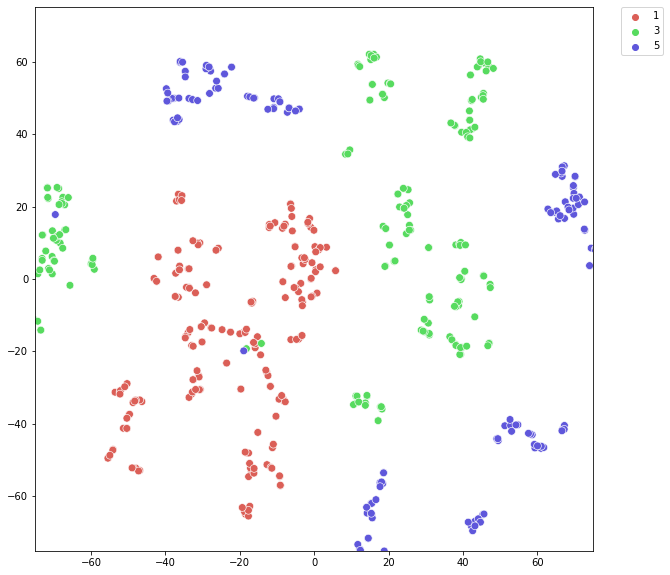

In [58]:
net = TemporalModel()  
model_directory = ".\models_KIMORE\models_KIMORE\Kimore_ex4.pt"
net.load_state_dict(torch.load(model_directory))
tsne = TSNE(n_components = 2, perplexity = 5, verbose = 0, random_state =42)
#         tsne = TSNE(n_components = 2, perplexity = 30, verbose = 2, random_state =42)

tsne_result = tsne.fit_transform(atten_tor)
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': atten_label})
fig, ax = plt.subplots(1, figsize= (10, 10))
s1 = sns.scatterplot(ax = ax, x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df,s=60, palette=sns.color_palette("hls", 3))
ax.set_xlim(-75,75)
ax.set_ylim(-75,75)
s1.get_legend().remove()
s1.set(xlabel=None)
s1.set(ylabel=None)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


In [ ]:
torch.save(atten_tor, 'eX1_attention.pt')
torch.save(atten_label, 'y1_attention.pt')

In [ ]:

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')